First off we load a JavaScript extension for yadage widget, so that we can track workflow progress visually

In [1]:
%%javascript
require.config({paths: {
        vis: "http://cdnjs.cloudflare.com/ajax/libs/vis/4.17.0/vis",
        yadage: "https://rawgit.com/lukasheinrich/yadage-ipython/master/yadagealpha"
    }
});

<IPython.core.display.Javascript object>

On the python side, we start with some basic imports...

In [2]:
import os
import shutil
from packtivity.statecontexts import poxisfs_context as statecontext
from yadage.yadagemodels import YadageWorkflow
from yadage.workflow_loader import workflow
from yadage.clihelpers import setupbackend_fromstring, prepare_workdir_from_archive
import logging
logging.basicConfig()

Now we prepare for running the workflow, cleaning up any residues of previous runs, loading the workflow spec from a public repository and setting workflow parameters

In [16]:
toplevel = 'https://raw.githubusercontent.com/lukasheinrich/weinberg-exp/master/example_yadage'

#clean up work directory
workdir = 'fromipython'
try:
    shutil.rmtree(workdir)
    prepare_workdir_from_archive(workdir, '{}/input.zip'.format(toplevel))
except OSError:
    pass

#load workflow 

#load the JSON wflow spec
wflowspec = workflow('rootflow.yml',toplevel) 
#define root workdirectory in which data fragements will end up 
rootcontext = statecontext.make_new_context(workdir)  
#finally create a workflow object
wflow = YadageWorkflow.createFromJSON(wflowspec,rootcontext)


#initialize workflow with parameters
wflow.view().init({
        'nevents':25000,
        'seeds':[1,2,3],
        'runcardtempl':'{}/init/run_card.templ'.format(os.path.realpath(workdir)),
        'proccardtempl':'{}/init/sm_proc_card.templ'.format(os.path.realpath(workdir)),
        'sqrtshalf':45,
        'polbeam1':0,
        'polbeam2':0
})

#set up a backend that we will use
backend = setupbackend_fromstring('multiproc:4') #options are: multiprocessing pool, ipython cluster, celery cluster

Now that we have the workflow ready, let's give ourselves a nice ui object with which we can interact

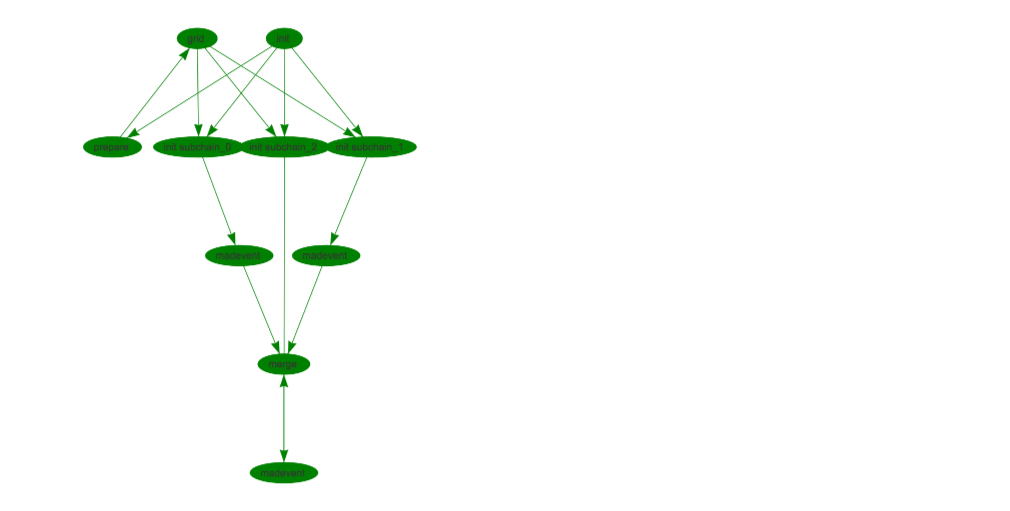

In [17]:
import yadage_widget
ui = yadage_widget.WorkflowWidget(wflow)
ui

One option is to run the workflow in *headless mode*, without any manual intervention

In [18]:
from adage import rundag
rundag(wflow, update_interval = 1, backend = backend,  additional_trackers=[ui.adagetracker])

Let's reset the workflow completely, so that we can demo some other nice features

In [19]:
#ui.reset('init')

There might be a need for having a more controlled execution of a workflow, in this case we can get a nide *manual* UI

Use the below cell to submit any submittable nodes

In [20]:
# with ui.manualctx(backend) as manual:
#     nodes = manual.submittable_nodes()
#     for x in nodes:
#         manual.submit_node(x)
#     #normally this would be completely async, but let's block here until all of the nodes we submitted in this pass
#     #are done
#     while not all([manual.state.dag.getNode(x).ready() for x in nodes]):
#         ui.adagetracker.track(manual.state) #updates the widget view
#         import time
#         time.sleep(1)
        

We can also reset specific steps (and thereby invalidate all of their descendents), to rerun part of the workflow

In [21]:
# ui.reset('madevent','/subchain/0')

We can get access the results of workflows and subworkflows

In [22]:
wflow.view().getSteps('merge')[0].result

{'jsonlinesfile': '/Users/lukas/Code/yadagedev/yadageipythonwidget/docker/fromipython/merge/out.jsonl'}

In [23]:
import json
with open(wflow.view().getSteps('merge')[0].result['jsonlinesfile']) as f:
    parsed = map(json.loads,f.readlines())

In [24]:
costhetas = []
for e in parsed:
    els = [p for p in e['particles'] if p['id'] == 11]
    mus = [p for p in e['particles'] if p['id'] == 13]
    assert len(mus) == 1
    assert len(els) == 1
    mu = mus[0]
    el = els[0]
    el_px, el_py, el_pz = [el[x] for x in ['px','py','pz']]
    mu_px, mu_py, mu_pz = [mu[x] for x in ['px','py','pz']]
    costheta = mu_pz/el_pz
    costhetas.append(costheta)

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

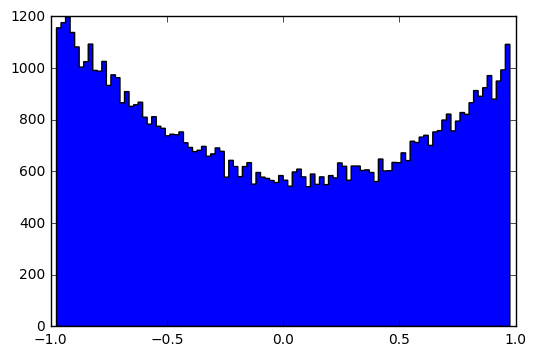

In [26]:
_,_,_ = plt.hist(costhetas, bins = 100, histtype='stepfilled')